# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: <br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;<br>
- Контролировать добросовестность кассиров при продаже алкоголя.<br>
- Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.<br>

План выполнения:
- Провести исследовательский анализ данных
- Подготовить данные к обучения 
- Обучить нейронную сеть и рассчитать её качество

## Импорт библиотек

In [4]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [5]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [6]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


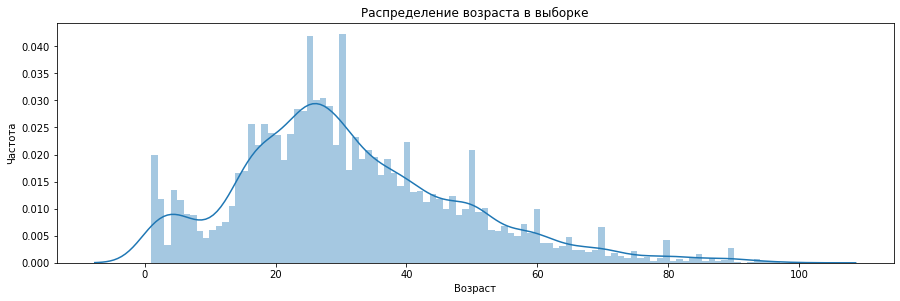

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(312)
sns.distplot(data['real_age'], bins=100)

plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.title("Распределение возраста в выборке")
plt.show()

**Вывод:** в датасете изображения с лицами людей в возрасте от 1 года до 100 лет, средний возраст равен примерно 31. При этом из распределения мы видим, что оно скошено, то есть, например, изображений людей в возрасте свыше 60 лет гораздо меньше, чем остальных. Возможно, наша модель научиться хорошо различать возраст 20-40 и плохо остальные возраста. 

В датасете 7591 изображение, это не мало и не много. Но для увеличения объёма данных, мы можем добавить данные прмиенив метод аугментации.

Также видны пики при каждом возрасте кратном 10, что может стать подспорьем в вопросе того, корректные данные в датасете или нет. Но будем считать, что на обучение модели это сильно не повлияет.

## Обзор датасета с изображениями

In [7]:
data_datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = (train_datagen.flow_from_dataframe(
                    dataframe=data, directory='/datasets/faces/final_files/',
                    x_col='file_name', 
                    y_col='real_age', 
                    target_size=(150, 150), 
                    batch_size=16, 
                    class_mode='raw', 
                    seed=12345
    )
)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

print(features.shape) 
print(target.shape) 

(16, 150, 150, 3)
(16,)


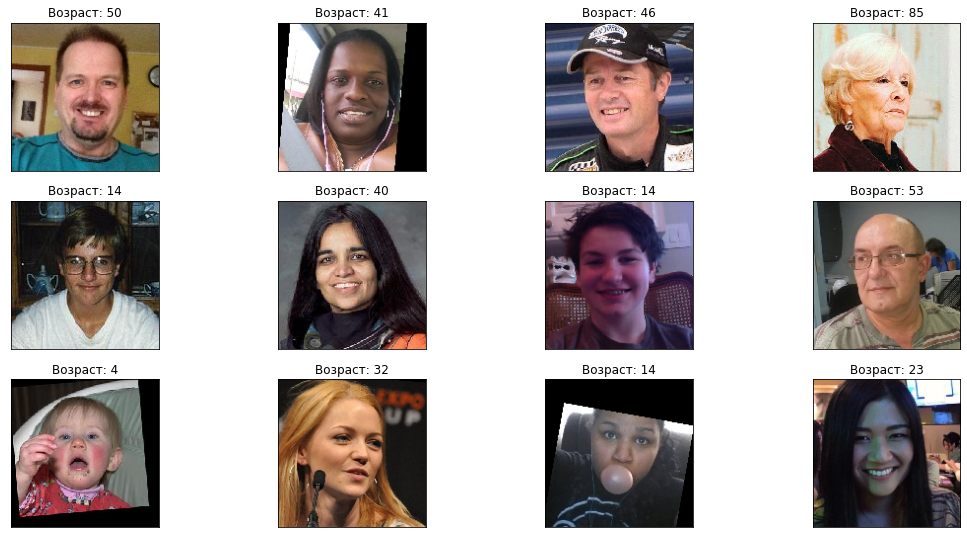

In [9]:
fig = plt.figure(figsize=(15,10))
count = 0
while count != 12:
    fig.add_subplot(4, 4, count + 1)
    
    plt.imshow(features[count])
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[count]))
    count += 1

**Вывод:** получившиеся признаки - 16 изображений размером 150 на 150 с тремя цветовыми каналами. С виду изображения корректные.

На следующем шаге приступим к обучению модели.

## Обучение модели

Код запускается на отдельном сервере с графической картой (GPU) Yandex Compute Cloud.

```python


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True,
                                       rescale=1/255.)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(150, 150), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
						     subset='training',
                                                     seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255.)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(150, 150), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
					             subset='validation', 
                                                     seed=12345)
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer=Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, 
                train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, 
                epochs=10, 
                steps_per_epoch=None, 
                validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)
 
    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    return model 


```

Результат работы кода:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 61s - loss: 249.1248 - mae: 11.3733 - val_loss: 582.3335 - val_mae: 18.7188
Epoch 2/10
356/356 - 40s - loss: 93.8081 - mae: 7.2919 - val_loss: 130.7944 - val_mae: 8.4871
Epoch 3/10
356/356 - 44s - loss: 60.1479 - mae: 5.9426 - val_loss: 108.9969 - val_mae: 8.1976
Epoch 4/10
356/356 - 43s - loss: 43.4370 - mae: 5.0620 - val_loss: 77.1775 - val_mae: 6.6964
Epoch 5/10
356/356 - 41s - loss: 32.4191 - mae: 4.3217 - val_loss: 78.6419 - val_mae: 6.8088
Epoch 6/10
356/356 - 44s - loss: 26.5348 - mae: 3.9068 - val_loss: 88.8758 - val_mae: 7.0610
Epoch 7/10
356/356 - 42s - loss: 19.6544 - mae: 3.3623 - val_loss: 79.3696 - val_mae: 6.5074
Epoch 8/10
356/356 - 42s - loss: 16.1650 - mae: 3.0739 - val_loss: 68.9329 - val_mae: 6.3019
Epoch 9/10
356/356 - 41s - loss: 13.7313 - mae: 2.8080 - val_loss: 64.6883 - val_mae: 6.0448
Epoch 10/10
356/356 - 41s - loss: 12.2354 - mae: 2.6422 - val_loss: 76.9768 - val_mae: 6.5295

119/119 - 10s - loss: 76.9768 - mae: 6.5295
Test MAE: 6.5295

```

## Анализ обученной модели

В данном проекте была построена модель, которая определяет возраст человека по изображения с ошибкой 6,5 лет.<br>
Ставились две бизнесовые задачи:<br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;<br>
- Контролировать добросовестность кассиров при продаже алкоголя.<br>

Модель обучалась нейронной сетью с архитектурой ResNet и весами ImageNet. <br>
Для того, чтобы увеличить первоначальное количество исходных изображений, была проведена аугментация, в точности, горизонтальное отображение.

- В качестве алгоритма оптимизации, использовался алгоритм Адам с шагом 0.0001. 
- В качестве функции потерь была MSE.
- Количество эпох было выбрано равным 10. Можно заметить, что даже на 10 эпохах модель сталкивается с переобучением.

Метрикой качества была выбрана MAE, итоговый результат: 6.5295

## Вывод

Задачей проекта было - разработать систему компьютерного зрения для обработки фотографий покупателей и опредления их возраста.

В ходе проекта был проведен анализ исходных данных, было замечено, что количество фотографий различных возрастов сильно отличается, что скорее всего повлияло на рост ошибки при определении возраста.

Далее была построена модель, которая обучалась на исходных изображениях (проведена аугментация: горизонтальное отражение) <br>

После, на отдельном сервере с графической картой была обучена модель, а также получены результаты на тестовой выборке. <br>

Метрикой качества была выбрана MAE. Итоговое значение на тесте: 6.5295.<br>